In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.primitives import Estimator
from ffsim import qiskit as fqs
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from ffsim.qiskit.jordan_wigner import jordan_wigner


from typing import Sequence
import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

import numpy as np
import quimb as qu
import quimb.tensor as qtn
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from functools import partial
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}
 
def create_linear_chains(norb: int) -> PyGraph:
    G = rustworkx.PyGraph()
 
    for n in range(norb):
        G.add_node(n)
 
    for n in range(norb - 1):
        G.add_edge(n, n + 1, None)
 
    for n in range(norb, 2 * norb):
        G.add_node(n)
 
    for n in range(norb, 2 * norb - 1):
        G.add_edge(n, n + 1, None)
 
    return G
 
def create_lucj_zigzag_layout(norb: int, backend_coupling_graph: PyGraph) -> tuple[PyGraph, int]:
    #Mapped to to an IBM QPU with heavy-hex connectivity
    isomorphic = False
    G = create_linear_chains(norb=norb)
    nit = norb
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(nit):
            if n % 4 == 0:
                new_node = 2 * norb + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + norb, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(backend_coupling_graph, G_new)
        nit -= 1
    return G_new, num_alpha_beta_qubits
 
 
def lightweight_layout_error_scoring(backend: BackendV2, virtual_edges: Sequence[Sequence[int]],physical_layouts: Sequence[int],two_q_gate_name: str,) -> list[list[list[int], float]]:
    # score isomporphic layouts based on the error rates of the qubits and couplers
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])
  
def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()
 
    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass
 
    return backend_coupling_graph
 
 
def get_zigzag_physical_layout(num_orbitals: int, backend: BackendV2, score_layouts: bool = True) -> tuple[list[int], int]:

    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)
 
    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        norb=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )
 
    isomorphic_mappings = rustworkx.vf2_mapping(backend_coupling_graph, G, subgraph=True)
    isomorphic_mappings = list(isomorphic_mappings)
 
    edges = list(G.edge_list())
 
    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)
 
    two_q_gate_name = IBM_TWO_Q_GATES.intersection(backend.configuration().basis_gates).pop()
 
    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )
 
        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits
 
    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits


/home/david/.venvs/tikzplot/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Classical chemistry

- Build $H_2$ molecule, basis, units, bond length
- obtain molecular and one and two electron integrals (hcore, eri) which define the fermionic electronic Hamiltonian
- use t1 and t2 amplitudes from ccsd ansatz to initialize lucj

In [2]:
open_shell = False
spin_sq = 0

atom = lambda R: [["H", (0, 0, 0)], ["H", (0, 0, R)]]
R = 0.75  

mol = pyscf.gto.Mole()
mol.build(atom=atom(R),basis="cc-pvdz",unit="Angstrom")
 
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr()) # include all atomic orbitals
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
norb = len(active_space)
print(norb)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, norb, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), norb)

nuclear_repulsion_energy = mol.energy_nuc()
mol_h = ffsim.MolecularHamiltonian(one_body_tensor=hcore, two_body_tensor=eri, constant=nuclear_repulsion_energy)
ferm_op = ffsim.fermion_operator(mol_h)

# actual qubit hammiltonian after JW
H = jordan_wigner(ferm_op, norb=norb)

converged SCF energy = -1.1287431347527
10


In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -1.137117245163172  E_corr = -0.02096579622456951


# initialize LUCJ and map to qubits via JW

In [4]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(0, norb, 4)]
 
# define lucj operator, initialize with t1, t2 amplitudes from ccsd
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=n_reps, interaction_pairs=(alpha_alpha_indices, alpha_beta_indices), optimize=True,options=dict(maxiter=1000))
 
# construct quantum circuit for lucj ansatz
nelec = (num_elec_a, num_elec_b)
qubits = QuantumRegister(2 * norb, name="q") # 2*N qubits for 2*N spin-orbitals
circuit_ucj = QuantumCircuit(qubits) 
circuit_ucj.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit_ucj.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit_ucj.measure_all()

In [34]:
service = QiskitRuntimeService()
backend = service.backend("ibm_torino")   
print(f"Using backend {backend.name}")

Using backend ibm_torino


In [6]:
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit_ucj)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}, \n depth: {isa_circuit.depth()}")

Gate counts (w/ pre-init passes): OrderedDict({'sx': 38, 'rz': 37, 'cz': 12, 'measure': 4, 'barrier': 1}), 
 depth: 33


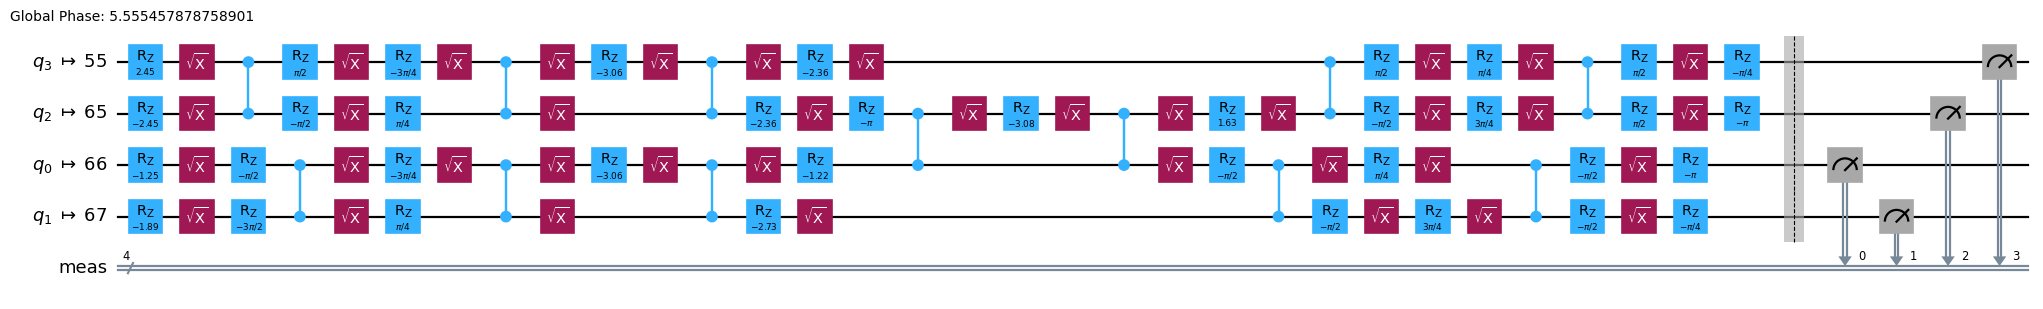

In [7]:
isa_circuit.draw("mpl", fold=50, scale=0.8)

# **Aer MPS simulator**

In [5]:
import tikzplotlib
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

plt.rcParams.update({"lines.markersize":3,
                     "xtick.major.size":3,
                     "xtick.minor.size":3,
                     "ytick.major.size":3,
                     "ytick.minor.size":3,
                     "xtick.direction":"in",
                     "ytick.direction":"in"})

plt.rcParams["axes.prop_cycle"] = cycler(color=["#ff0000", "#259f00", "#ff7700", "#00ffd5", "#1500ff", "#9000ff", "#ff00b3", "#646464", "#ffff00", "#00ffb3"])


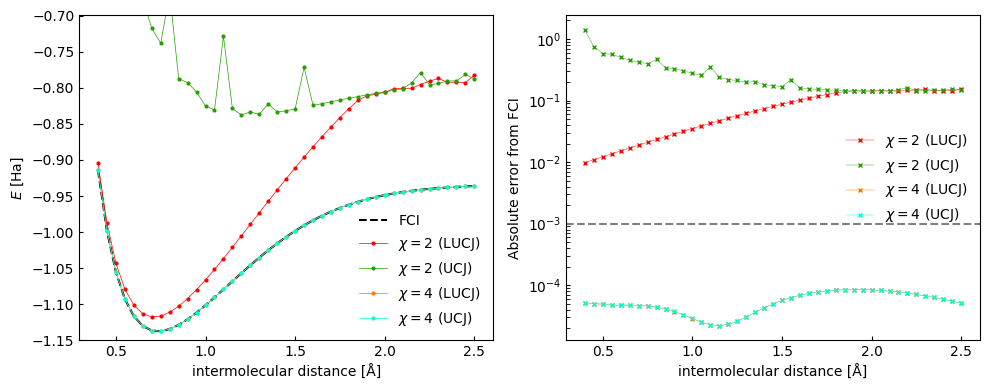

In [101]:
d = pd.read_csv("../data/classical/h2_sto-3g.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()



bds = [2,4]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(R, E_FCI, "k--", label="FCI", lw=1.5)


for bd in bds:
    data = pd.read_csv(f"../data/mps/sto-3g/h2_sto-3g_bd={bd}.csv")
    data2 = pd.read_csv(f"../data/mps/sto-3g/h2_sto-3g_bd={bd}_ucj.csv")

    ax1.plot(data["R_AA"].to_numpy(), data["E_lucj_opt"].to_numpy(),
             label=rf"$\chi = {bd}$ (LUCJ)", marker='o', markersize=2, lw=0.5)
    ax1.plot(data2["R"].to_numpy(), data2["E"].to_numpy(),
             label=rf"$\chi = {bd}$ (UCJ)", marker='o', markersize=2, lw=0.5)
    ax2.semilogy(R, np.abs(E_FCI - data["E_lucj_opt"].to_numpy()), label=rf"$\chi = {bd}$ (LUCJ)", marker='x', markersize=3, lw=0.3)
    ax2.semilogy(R, np.abs(E_FCI - data2["E"].to_numpy()), label=rf"$\chi = {bd}$ (UCJ)", marker='x', markersize=3, lw=0.3)


ax1.set_xlabel(f"intermolecular distance [Å]")
ax1.set_ylabel(rf"$E$ [Ha]")
ax1.set_ylim([-1.15,-0.7])
ax2.axhline(1e-3, ls='--', c='gray')

ax2.set_xlabel(f"intermolecular distance [Å]")
ax2.set_ylabel(r"Absolute error from FCI")

ax1.legend(framealpha=0.0)
ax2.legend(framealpha=0.0)

plt.tight_layout()
tikzplotlib.save( "figures/H2_sto-3g_mps.tex", axis_width="0.5\\linewidth", axis_height="0.4\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )


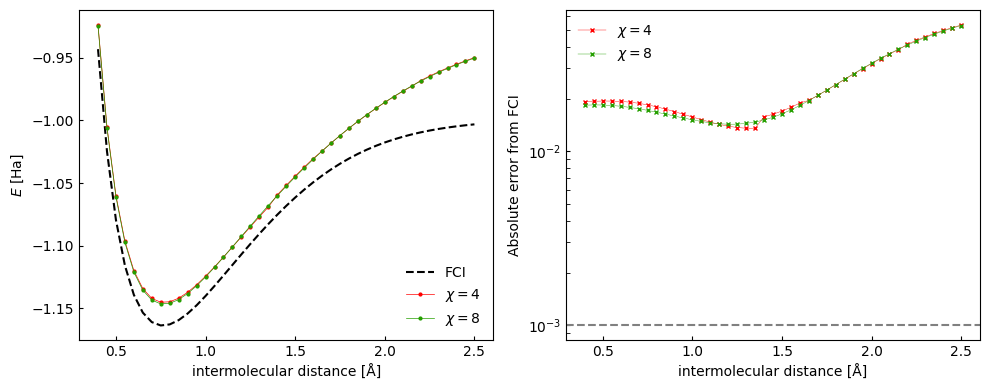

In [50]:
d = pd.read_csv("../data/classical/h2_cc-pVDZ.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()

bds = [4,8]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(R, E_FCI, "k--", label="FCI", lw=1.5)

for bd in bds:
    data = pd.read_csv(f"../data/mps/cc-pvdz/h2_cc-pvdz_bd={bd}.csv")
    ax1.plot(data2["R"].to_numpy(), data["E_lucj"].to_numpy(),
             label=rf"$\chi = {bd}$", marker='o', markersize=2, lw=0.5)
    ax2.semilogy(R, np.abs(E_FCI - data["E_lucj"].to_numpy()), label=rf"$\chi = {bd}$", marker='x', markersize=3, lw=0.3)


ax1.set_xlabel(f"intermolecular distance [Å]")
ax1.set_ylabel(rf"$E$ [Ha]")
ax2.axhline(1e-3, ls='--', c='gray')

ax2.set_xlabel(f"intermolecular distance [Å]")
ax2.set_ylabel(r"Absolute error from FCI")

ax1.legend(framealpha=0.0)
ax2.legend(framealpha=0.0)

plt.tight_layout()
tikzplotlib.save( "figures/H2_cc-pvdz_mps.tex", axis_width="0.5\\linewidth", axis_height="0.4\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )


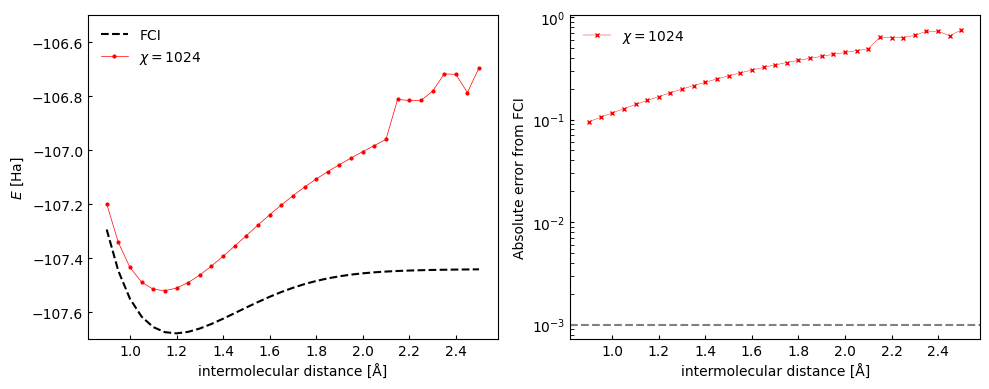

In [102]:
d = pd.read_csv("../data/classical/n2_sto-3g.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()

bds = [1024]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(R, E_FCI, "k--", label="FCI", lw=1.5)
ax1.set_ylim([np.min(E_FCI)-5e-2, np.max(E_FCI)])

for bd in bds:
    data = pd.read_csv(f"../data/mps/sto-3g/n2_sto-3g_bd={bd}.csv")
    ax1.plot(data["R"].to_numpy(), data["E"].to_numpy(),
             label=rf"$\chi = {bd}$", marker='o', markersize=2, lw=0.5)
    ax2.semilogy(R, np.abs(E_FCI - data["E"].to_numpy()), label=rf"$\chi = {bd}$", marker='x', markersize=3, lw=0.3)


ax1.set_xlabel(f"intermolecular distance [Å]")
ax1.set_ylabel(rf"$E$ [Ha]")
ax1.set_ylim([-107.7, -106.5])
ax2.axhline(1e-3, ls='--', c='gray')

ax2.set_xlabel(f"intermolecular distance [Å]")
ax2.set_ylabel(r"Absolute error from FCI")

ax1.legend(framealpha=0.0)
ax2.legend(framealpha=0.0)

plt.tight_layout()
tikzplotlib.save( "figures/n2_mps.tex", axis_width="0.5\\linewidth", axis_height="0.4\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )

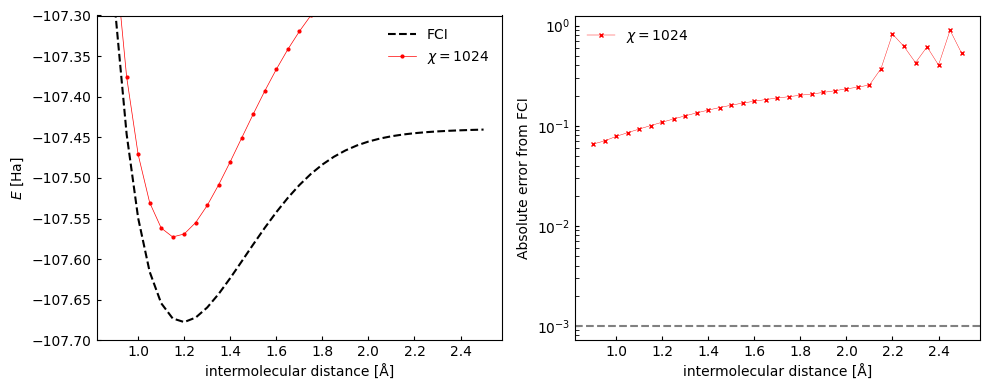

In [98]:
d = pd.read_csv("../data/classical/n2_sto-3g.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()

bds = [1024]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(R, E_FCI, "k--", label="FCI", lw=1.5)
ax1.set_ylim([np.min(E_FCI)-5e-2, np.max(E_FCI)])

for bd in bds:
    data = pd.read_csv(f"../data/mps/sto-3g/n2_sto-3g_bd={bd}.csv")
    ax1.plot(data["R"].to_numpy(), data["E"].to_numpy(),
             label=rf"$\chi = {bd}$", marker='o', markersize=2, lw=0.5)
    ax2.semilogy(R, np.abs(E_FCI - data["E"].to_numpy()), label=rf"$\chi = {bd}$", marker='x', markersize=3, lw=0.3)


ax1.set_xlabel(f"intermolecular distance [Å]")
ax1.set_ylabel(rf"$E$ [Ha]")
ax1.set_ylim([-107.7, -107.3])
ax2.axhline(1e-3, ls='--', c='gray')

ax2.set_xlabel(f"intermolecular distance [Å]")
ax2.set_ylabel(r"Absolute error from FCI")

ax1.legend(framealpha=0.0)
ax2.legend(framealpha=0.0)

plt.tight_layout()
tikzplotlib.save( "figures/n2_mps.tex", axis_width="0.5\\linewidth", axis_height="0.4\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )

# **Submit sampler job on IBM-Q**
We collect bitstring samples for ground state energy esimation.

In [ ]:
# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=100_000)

# Job results

In [19]:
service = QiskitRuntimeService(channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/d0452a76f5f0435a94da777e07d63524:02dde04a-2cef-4099-97bb-ee03dd1b86e5::')

job = service.job('d321g4e6dbus73d7phig')
primitive_result = job.result()
pub_result = primitive_result[0]
bitstring_samples = pub_result.data.meas # noisy bitstrings

We estimate the ground state energy of the Hamiltonian using `diagonalize_fermionic_hamiltonian` function from qiskit. This performs self-consistent configuration recovery to approximate CI coefficients.

We send the bitstring samples into a CI subspace and diagonalize them with SQD in this subspace, subject to constraints (symmetric spin, spin singlets)

In [ ]:
# post processing job result with SCI
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=200)

# self consistent configuration recovery and sample-based quantum diagonalization
preproc_res = diagonalize_fermionic_hamiltonian(hcore, eri, bitstring_samples, samples_per_batch=300,
    norb=norb, nelec=nelec, num_batches=3, energy_tol=1e-3, occupancies_tol=1e-3,
    max_iterations=5, sci_solver=sci_solver, symmetrize_spin=True,
    carryover_threshold=1e-4, seed=12345)

preproc_energy = preproc_res.energy.real + nuclear_repulsion_energy

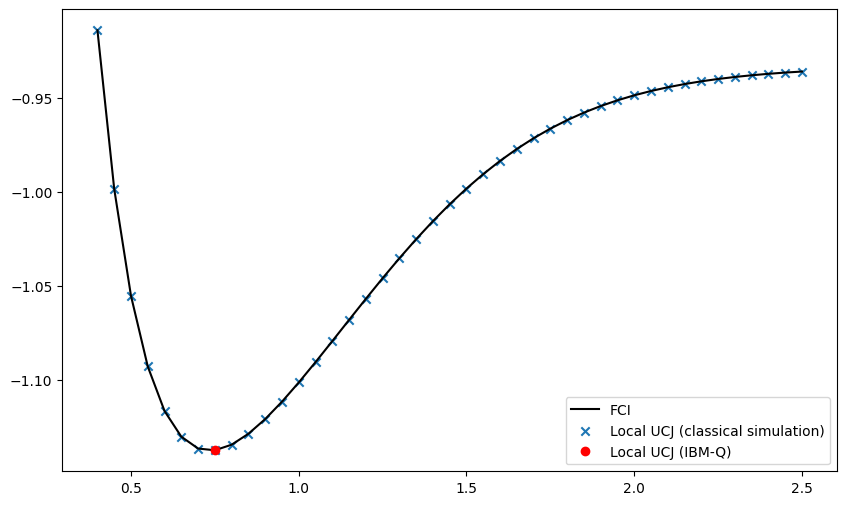

In [ ]:
d = pd.read_csv("../data/h2_sto-3g.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()

series = {
    "CCSD": d["E_CCSD"].to_numpy(),
    "uCJ": d["E_uCJ"].to_numpy(),
    "2-uCJ": d["E_2uCJ"].to_numpy(),
    "LuCJ": d["E_L-1uCJ"].to_numpy(),
    "2-LuCJ": d["E_L-2uCJ"].to_numpy(),
    "1-LuCJ(opt)": d["E_L-1uCJ_opt"].to_numpy(),
    "2-LuCJ(opt)": d["E_L-2uCJ_opt"].to_numpy(),
}

err = {k: np.abs(v - E_FCI) for k, v in series.items()}

plt.figure(figsize=(10, 6))
plt.plot(R, E_FCI, "k-", label="FCI")
plt.scatter(R, series["1-LuCJ(opt)"], label="Local UCJ (classical simulation)", marker='x')
plt.plot(0.75, preproc_energy, "ro", label="Local UCJ (IBM-Q)")
plt.legend()
plt.show()


In [ ]:
open_shell = False
spin_sq = 0

atom = lambda R: [["H", (0, 0, 0)], ["H", (0, 0, R)]]
R = 0.75  

mol = pyscf.gto.Mole()
mol.build(atom=atom(R),basis="cc-pvdz",unit="Angstrom")
 
# Define active space
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
norb = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, norb, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), norb)

nuclear_repulsion_energy = mol.energy_nuc()
mol_h = ffsim.MolecularHamiltonian(one_body_tensor=hcore, two_body_tensor=eri, constant=nuclear_repulsion_energy)
ferm_op = ffsim.fermion_operator(mol_h)

# actual qubit hammiltonian after JW
H = jordan_wigner(ferm_op, norb=norb)

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(0, norb, 4)]

ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2
 
# define lucj operator, initialize with t1, t2 amplitudes from ccsd
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=n_reps, interaction_pairs=(alpha_alpha_indices, alpha_beta_indices), optimize=True,options=dict(maxiter=1000))
 
# construct quantum circuit for lucj ansatz
nelec = (num_elec_a, num_elec_b)
qubits = QuantumRegister(2 * norb, name="q") # 2*N qubits for 2*N spin-orbitals
circuit_ucj = QuantumCircuit(qubits) 
circuit_ucj.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit_ucj.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit_ucj.measure_all()

pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit_ucj)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}, \n depth: {isa_circuit.depth()}")

# here we have sent the qubit hamiltonian circuit to ibm-q and retrieved result from measumrent
job = service.job('d321sge6dbus73d7pss0')
primitive_result = job.result()
pub_result = primitive_result[0]

# post processing job result with SCI
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=200)

# self consistent configuration recovery and sample-based quantum diagonalization
preproc_res = diagonalize_fermionic_hamiltonian(hcore, eri, pub_result.data.meas, samples_per_batch=300,
    norb=norb, nelec=nelec, num_batches=3, energy_tol=1e-3, occupancies_tol=1e-3,
    max_iterations=5, sci_solver=sci_solver, symmetrize_spin=True, carryover_threshold=1e-4, seed=12345)

preproc_energy = preproc_res.energy.real + nuclear_repulsion_energy

converged SCF energy = -1.1287431347527
E(CCSD) = -1.163593566977586  E_corr = -0.03485043222488789
Gate counts (w/ pre-init passes): OrderedDict({'rz': 352, 'sx': 341, 'cz': 174, 'x': 50, 'measure': 20, 'barrier': 1}), 
 depth: 129


In [38]:
# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5
 
# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200
 
# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
 
# List to capture intermediate results
result_history = []
 
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
 
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=norb,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -1.1635935606523766
		Subspace dimension: 100
	Subsample 1
		Energy: -1.1635935606523766
		Subspace dimension: 100
	Subsample 2
		Energy: -1.1635935606523766
		Subspace dimension: 100
Iteration 2
	Subsample 0
		Energy: -1.1635935606523766
		Subspace dimension: 100
	Subsample 1
		Energy: -1.1635935606523766
		Subspace dimension: 100
	Subsample 2
		Energy: -1.1635935606523766
		Subspace dimension: 100


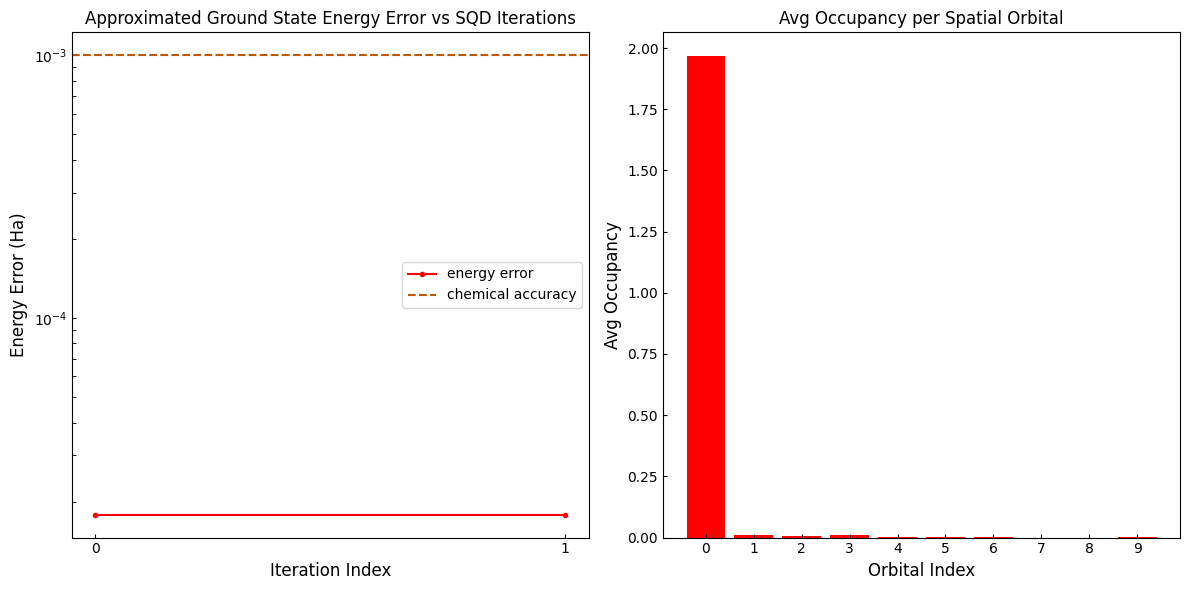

In [44]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - np.min(E_FCI)) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
 
# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001
 
# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))
 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
 
# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()
 
# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
 
plt.tight_layout()
plt.show()

cc-pvdz

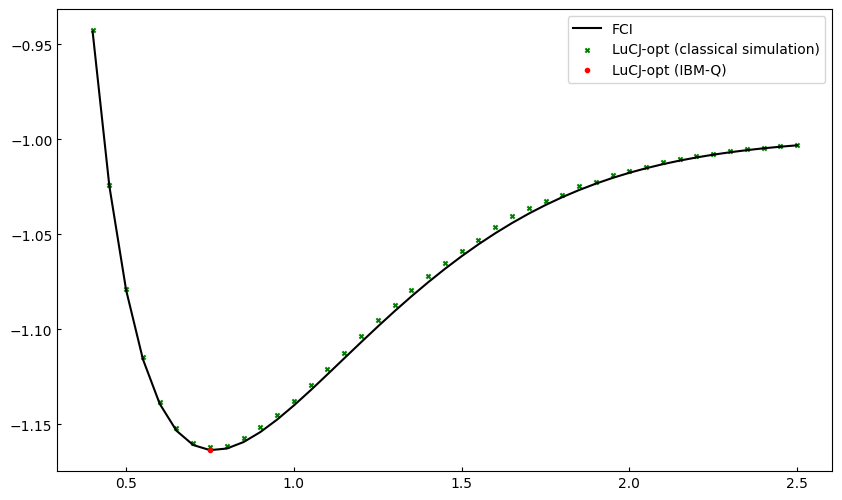

In [37]:
d = pd.read_csv("../data/classical/h2_cc-pVDZ.csv")
R = d["R_AA"].to_numpy()
E_FCI = d["E_FCI"].to_numpy()

series = {
    "CCSD": d["E_CCSD"].to_numpy(),
    "uCJ": d["E_uCJ"].to_numpy(),
    "2-uCJ": d["E_2uCJ"].to_numpy(),
    "LuCJ": d["E_L-1uCJ"].to_numpy(),
    "2-LuCJ": d["E_L-2uCJ"].to_numpy(),
    "1-LuCJ(opt)": d["E_L-1uCJ_opt"].to_numpy(),
    "2-LuCJ(opt)": d["E_L-2uCJ_opt"].to_numpy(),
}

err = {k: np.abs(v - E_FCI) for k, v in series.items()}

plt.figure(figsize=(10, 6))
plt.plot(R, E_FCI, "k-", label="FCI")
plt.scatter(R, series["1-LuCJ(opt)"], label="LuCJ-opt (classical simulation)", marker='x', c='g')
plt.plot(0.75, preproc_energy, "ro", label="LuCJ-opt (IBM-Q)")
plt.legend()
tikzplotlib.save( "figures/H2_ccpvdz-ibmq.tex", axis_width="0.5\\linewidth", axis_height="0.4\\linewidth", textsize=6, extra_axis_parameters=[ "tick label style={font=\\scriptsize}", "label style={font=\\footnotesize}", "title style={font=\\footnotesize}", "legend style={font=\\scriptsize}", ], extra_groupstyle_parameters=[ "horizontal sep=1.75cm" ] )

plt.show()

In [ ]:
print(abs(np.min(series["CCSD"])-(np.min(E_FCI))))
print(abs(preproc_energy-(np.min(E_FCI))))

1.9279999818877513e-09
1.7838881623877256e-05


# Tensor network

In [26]:
from qiskit import QuantumCircuit
from qiskit.circuit import Instruction

def _to_num(x):
    try:
        return float(x)
    except Exception:
        return str(x)

def serialize_circuit(circuit: QuantumCircuit, *, compact: bool = False):
    ops = []
    for instr in circuit.data:
        ops.append({
            "name": instr.operation.name,
            "params": [_to_num(p) for p in instr.operation.params],
            "qubits": [circuit.find_bit(q).index for q in instr.qubits],
            "clbits": [circuit.find_bit(c).index for c in instr.clbits],
        })
    used = sorted({q for op in ops for q in op["qubits"]})
    if compact:
        qmap = {q:i for i,q in enumerate(used)}
        for op in ops:
            op["qubits"] = [qmap[q] for q in op["qubits"]]
        num_qubits = len(used)
    else:
        num_qubits = circuit.num_qubits
    per_qubit = {i: [] for i in range(num_qubits)}
    for i, op in enumerate(ops):
        for q in op["qubits"]:
            per_qubit[q].append(i)
    return {
        "num_qubits": num_qubits,
        "num_clbits": circuit.num_clbits,
        "ops": ops,
        "per_qubit": per_qubit,
        "used_qubits": used,
        "original_num_qubits": circuit.num_qubits,
        "compact": compact,
    }

def reconstruct_circuit(data, *, physical_layout: bool = False):
    if data.get("compact", False) and physical_layout and data["used_qubits"]:
        nq = data["original_num_qubits"]
        qc = QuantumCircuit(nq, data["num_clbits"])
        for op in data["ops"]:
            qargs = [qc.qubits[data["used_qubits"][q]] for q in op["qubits"]]
            cargs = [qc.clbits[i] for i in op["clbits"]]
            if op["name"] == "measure":
                for q, c in zip(qargs, cargs):
                    qc.measure(q, c)
            elif hasattr(qc, op["name"]):
                getattr(qc, op["name"])(*op["params"], *qargs)
            else:
                inst = Instruction(op["name"], len(qargs), len(cargs), op["params"])
                qc.append(inst, qargs, cargs)
        return qc
    qc = QuantumCircuit(data["num_qubits"], data["num_clbits"])
    for op in data["ops"]:
        qargs = [qc.qubits[i] for i in op["qubits"]]
        cargs = [qc.clbits[i] for i in op["clbits"]]
        if op["name"] == "measure":
            for q, c in zip(qargs, cargs):
                qc.measure(q, c)
        elif hasattr(qc, op["name"]):
            getattr(qc, op["name"])(*op["params"], *qargs)
        else:
            inst = Instruction(op["name"], len(qargs), len(cargs), op["params"])
            qc.append(inst, qargs, cargs)
    return qc

def per_qubit_tapes(circuit: QuantumCircuit, *, compact: bool = False):
    data = serialize_circuit(circuit, compact=compact)
    tapes = {q: [] for q in data["per_qubit"]}
    for q, idxs in data["per_qubit"].items():
        for i in idxs:
            op = data["ops"][i]
            tapes[q].append((op["name"], op["params"], op["qubits"], op["clbits"], i))
    return data, tapes

s = serialize_circuit(isa_circuit, compact=True)
tapes = per_qubit_tapes(isa_circuit, compact=True)
qc2 = reconstruct_circuit(s)

In [27]:
import quimb.tensor as qtn

QISKIT_TO_QUIMB = {
    "x": "X",
    "y": "Y",
    "z": "Z",
    "h": "H",
    "s": "S",
    "sdg": "SDG",
    "t": "T",
    "tdg": "TDG",
    "sx": "SX",
    "sxdg": "SXD",
    "rx": "RX",
    "ry": "RY",
    "rz": "RZ",
    "cx": "CX",
    "cz": "CZ",
    "swap": "SWAP",
}

def serialized_to_quimb_circuit(ser):
    N = ser["num_qubits"]
    circ = qtn.Circuit(N=N)
    gate_round = 0
    for op in ser["ops"]:
        name = op["name"].lower()
        if name == "measure":
            continue
        qname = QISKIT_TO_QUIMB.get(name)
        if qname is None:
            continue
        params = op["params"]
        qubits = op["qubits"]
        args = list(params) + list(qubits)
        circ.apply_gate(qname, *args, gate_round=gate_round)
        gate_round += 1
    return circ

data = serialize_circuit(isa_circuit, compact=True)
qcirc = serialized_to_quimb_circuit(data)


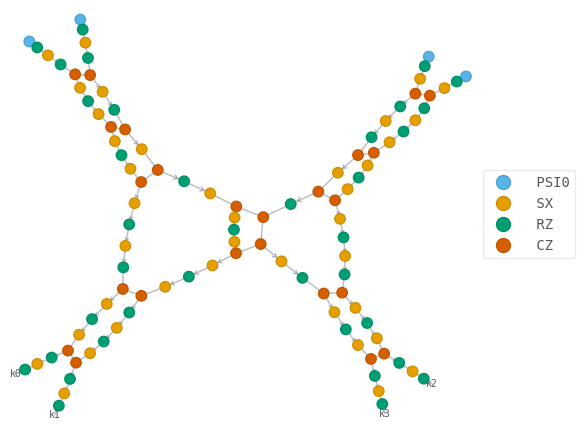

In [28]:
qcirc.psi.draw(color=['PSI0', 'SX', 'RZ', 'CZ'])


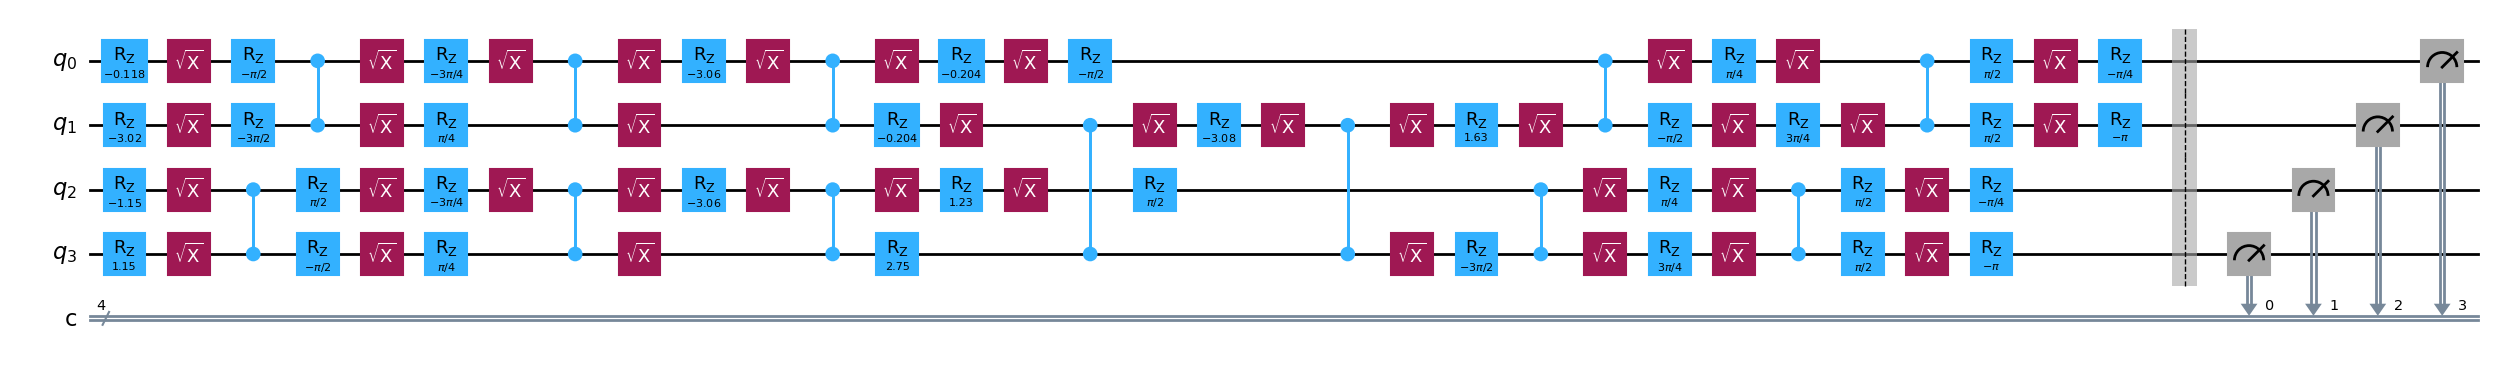

In [29]:
qc2.draw('mpl', fold=50)

In [10]:
# h2_lucj_fit_to_fci_mps.py
import numpy as np
import pyscf.gto, pyscf.scf, pyscf.mcscf, pyscf.ao2mo
import ffsim
from ffsim import qiskit as fqs
from ffsim.qiskit import jordan_wigner

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# === TN addon (v0.2) ===
# ⬅️ FIX THESE IMPORTS
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity


# === quimb MPS ===
import quimb as qu
import quimb.tensor as qtn

from qiskit import transpile

def to_quimb_basis(qc):
    # fully peel composites
    for _ in range(4):
        qc = qc.decompose()
    # unroll to gates quimb maps (no 'u')
    qc = transpile(
        qc,
        basis_gates=['rz','sx','x','cz','cx','swap','id'],
        optimization_level=1,
    )
    # safety: ensure no 'u' left
    assert 'u' not in qc.count_ops(), qc.count_ops()
    return qc

# ---------- chemistry bits: H2 / sto-3g ----------
R = 0.75  # Angstrom
basis = "sto-3g"

mol = pyscf.gto.Mole()
mol.build(atom=[("H", (0,0,0)), ("H", (0,0,R))], basis=basis, unit="Angstrom", verbose=0)
scf = pyscf.scf.RHF(mol).run()

# active space = all orbitals
active = range(mol.nao_nr())
norb = len(list(active))
nelec = (int(sum(scf.mo_occ[active]))//2, int(sum(scf.mo_occ[active]))//2)  # (na, nb)
n_qubits = 2 * norb

# CAS-based integrals in MO active space
cas = pyscf.mcscf.CASCI(scf, norb, nelec)
mo  = cas.sort_mo(active, base=0)
h1, _ = cas.get_h1cas(mo)
h2    = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), norb)
e_nuc = mol.energy_nuc()

# JW Hamiltonian (Qiskit SparsePauliOp)
mol_h = ffsim.MolecularHamiltonian(h1, h2, constant=e_nuc)
ferm  = ffsim.fermion_operator(mol_h)
H_spo: SparsePauliOp = jordan_wigner(ferm, norb=norb)

# Dense matrix (small: 4 qubits) -> exact ground state vector
H_dense = H_spo.to_matrix()  # (2^n x 2^n)
evals, evecs = np.linalg.eigh(H_dense)
E_fci = float(evals[0].real)
psi0 = evecs[:, 0]  # FCI ground state |psi_target>

# --- target MPS (quimb) ---
dims = [2] * n_qubits  # one qubit per physical index
mps_target = qtn.MatrixProductState.from_dense(
    psi0,                # 1D statevector length 2**n
    dims=dims,           # tell quimb how to reshape
    max_bond=None,       # no truncation on build
    cutoff=0.0,          # exact
    method="svd",
)

# Optional compression (keeps it exact for small n if cutoff tiny)
mps_target.compress(max_bond=128, cutoff=1e-12)

# ---------- build LuCJ ansatz circuit ----------
def interleave_perm(norb: int):
    return [p for k in range(norb) for p in (k, k + norb)]

def prepare_lucj_circuit(norb, nelec, x, n_reps=1, interleave=True, with_orb_rot=True, pairs=None):
    qreg = QuantumRegister(2*norb, "q")
    qc = QuantumCircuit(qreg)

    # spin-interleaved layout helps MPS
    if interleave:
        perm = interleave_perm(norb)
        phys = [qreg[i] for i in perm]
    else:
        phys = list(qreg)

    hf = fqs.PrepareHartreeFockJW(norb, nelec)
    ucj = ffsim.UCJOpSpinBalanced.from_parameters(
        x, norb=norb, n_reps=n_reps, interaction_pairs=pairs,
        with_final_orbital_rotation=with_orb_rot
    )
    qc.append(hf, phys)
    qc.append(fqs.UCJOpSpinBalancedJW(ucj), phys)

    # fully decompose to 1–2q basis (safe for TN backends)
    for _ in range(4):
        qc = qc.decompose()
    return qc

# pairs: local ladder (α-α NN, α-β rungs)
def local_pairs(norb: int):
    aa = [(p, p+1) for p in range(norb-1)]
    ab = [(p, p)    for p in range(norb)]
    return (aa, ab)

pairs = local_pairs(norb)
# seed parameters from CCSD (good init)
t1 = np.zeros((norb, norb))  # (not used by UCJ-balanced, fine)
# simple physically reasonable seed: small random
rng = np.random.default_rng(0)
x0 = 0.02 * rng.standard_normal(ffsim.UCJOpSpinBalanced.n_params(norb=norb, n_reps=1, interaction_pairs=pairs, with_final_orbital_rotation=True))

ansatz = prepare_lucj_circuit(norb, nelec, x0, n_reps=1, interleave=True, with_orb_rot=True, pairs=pairs)
ansatz = to_quimb_basis(ansatz)  
from functools import partial
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity

# quimb backend settings (MPS)
sim_settings = QuimbSimulator(
    partial(qtn.CircuitMPS, gate_opts={"cutoff": 1e-12, "max_bond": 256}),
    autodiff_backend="jax",
)

# target is your quimb MPS
target_tn = mps_target

# (optional) make a TN from the circuit for debugging/inspection
_ = tensornetwork_from_circuit(ansatz, sim_settings)

# objective: target TN + ansatz circuit + settings
obj = MaximizeStateFidelity(target_tn, ansatz, sim_settings)

import scipy.optimize
res = scipy.optimize.minimize(
    fun=obj.loss_function, x0=x0, method="L-BFGS-B", jac=True,
    options=dict(maxiter=1000, ftol=1e-12, gtol=1e-10),
)
theta_opt = res.x
print("loss (1-F):", float(res.fun))


# ---------- Evaluate energy with the fitted LuCJ circuit ----------
lucj_opt = prepare_lucj_circuit(norb, nelec, theta_opt, n_reps=1, interleave=True, with_orb_rot=True, pairs=pairs)

# Use Aer MPS in exact/double mode for a clean ⟨H⟩
sim_mps = AerSimulator(method="matrix_product_state")
sim_mps.set_options(
    matrix_product_state_max_bond_dimension=4,
    matrix_product_state_truncation_threshold=0.0,
    precision="double",
)
basis = sim_mps.configuration().basis_gates
lucj_opt = transpile(lucj_opt, backend=sim_mps, basis_gates=basis, optimization_level=1)
lucj_opt.save_expectation_value(H_spo, range(n_qubits), label="E")
E_fit = sim_mps.run(lucj_opt, shots=0).result().data(0)["E"].real

print(f"E_FCI        = {E_fci:+.12f}")
print(f"E_LuCJ(fit)  = {E_fit:+.12f}")
print("ΔE (Hartree) =", E_fit - E_fci)


loss (1-F): 1.0
E_FCI        = -1.137117067346
E_LuCJ(fit)  = -0.542053265724
ΔE (Hartree) = 0.5950638016215242


/home/david/.venvs/tikzplot/lib/python3.12/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(
